# Developing a KPI to the Slip-to-Slip Connection Time in a Drilling Operation

## Summary

I delivered here a complete data-driven solution to monitor crew performance in drilling operations from an Oil & Gas company. The performance is measured according to the time taken to perform the slip-to-slip connection.

After a careful exploratory data analysis, I selected relevant measurements that come from a variety of sensors to create a machine learning model that is able to reliably categorize whether the slips are holding the upper part of a drill pipe. Since sensors give the timestamp for each measurement, after predicting the slips state, we can calculate the time it took for the crew to complete the process of connecting pipes.

This solution provides an automated way to monitor the crew performance saving the company time, and money.

## Introduction

Measurement of performance is vital to business success and most performance studies are
related to the so-called key performance indicators (KPI). A KPI measures how well the
organization is performing on operational, tactical or strategic activities. This is critical for the
current and future success of the organization.

In the Oil and Gas industry, a KPI can be used to monitor and measure operational quality and
crew performance. In a Drilling operation, the process where a hole is bored using a drill bit to
create a well for oil and natural gas production, an example of KPI is the Slip to Slip connection
time. This KPI can offer significant improvements in identifying sources of Non-Productive time.

The slip is a device used to grip and hold the upper part of a drill pipe to the drill floor, which is
the area where the pipe begins its trip into the earth. The Slips are used when making a
connection: the pipes are joined in order to advance further into the hole. Therefore, each pipe
is picked up by a hook, temporarily gripped by the slips and then joined to another pipe. After
the joint, the slips are removed and the entire pipe is carefully lowered into the hole, resuming
the drilling. A skilled rig crew can physically accomplish all of those steps in a minute or two.

In this challenge, my goal is to perform an Exploratory Data Analysis to extract useful
information for the development of the above-mentioned KPI. Further, I need to create an ML model to monitor the performance of the rig crew in a drilling operation. 

## Getting Started

In [1]:
## --- data visualization and data structues libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## --- preprocessing libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline

## --- machine learning libraries (supervised)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

## --- machine learning libraries (unsupervised)
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans


## --- evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


import pickle

## --- handy user-defined functions
from subroutines import reduce_mem_usage, display_feat_import, tryconvert
from subroutines import display_percent_count_plot, cf_matrix_labels, dist_medians
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

#### First look

First, we have a look at the received dataset so that we can get familiarized with the features and data types. 

In [2]:
df = reduce_mem_usage(pd.read_csv('./input/challenge_data.csv', engine='c', index_col=0))
df.head(5)

Memory usage of dataframe is 2.79 MB


  0%|          | 0/8 [00:00<?, ?it/s]

Memory usage after optimization is: 0.93 MB
Decreased by 66.7%


,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB
1.607131e+12,5064.0,19.546875,522.5,18.984375,0.0,0.0,5796.0,13.382812
1.607131e+12,5064.0,15.585938,523.0,19.062500,0.0,0.0,5796.0,12.726562
1.607131e+12,5064.0,18.484375,524.5,19.156250,0.0,0.0,5796.0,11.453125
1.607131e+12,5064.0,16.109375,525.0,19.250000,0.0,0.0,5796.0,10.843750
1.607131e+12,5064.0,17.703125,526.0,19.343750,0.0,0.0,5796.0,9.812500


In [3]:
annot = pd.read_csv('./input/challenge_annotation.csv', engine='c', index_col=0)

In [4]:
df.dtypes

BDEP    float16
TPO     float16
HL      float16
BHT     float16
RPM     float16
TOR     float16
DEPT    float16
WOB     float16
dtype: object

In [5]:
annot.dtypes

Annotation    object
dtype: object

In [6]:
## --- converting types to reduce memory usage
df['BDEP'] = df['BDEP'].astype('int')

Now we look for columns that contain at least one missing value. If so, we check the percentage of occurrence of these values in certain columns. 

In [7]:
if df.isna().any().sum()==0:
    print('There is no missing values in the dataset.')
else:
    print('There may be some inconsistency.')

There may be some inconsistency.


In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
pd.DataFrame({'column_name': df.columns,
              'percent_missing': percent_missing})

,column_name,percent_missing
BDEP,BDEP,0.000000
TPO,TPO,0.031962
HL,HL,0.004917
BHT,BHT,0.036880
RPM,RPM,0.063924
TOR,TOR,0.041797
DEPT,DEPT,0.054090
WOB,WOB,0.054090


In [9]:
df.dropna(axis = 0, how='all', inplace=True)

In [10]:
no_nan = df.dropna(axis = 0, how = 'any').copy()

Most features have a tiny number of missing values. So, after removing rows containing only missing values, my fisrt approach will be filling these gaps with a arbitrary number so that the model may capture.

In [11]:
for col in df.columns[1:]:
    df[col].fillna(-3290, inplace=True)

### Exploratory Data Analysis (EDA)

Before tackling the problem by creating a computational model, I go for a detailed exploratory data analysis (EDA). By doing so, I can categorize the failures according to the predictors, calculate the number of occurrences, check for possible unbalances in the target classes, get insights about feature importance, visualize outliers, and much more. This step is important for many reasons, but the one I'd like to emphasize here is that the EDA underlies my decisions when selecting the appropriate algorithms to create a model.

#### Occurence Analysis

The occurrence analysis is quite simple: it examines the number of '*off_slips*' annotations against the number of '*on_slips*' annotations.

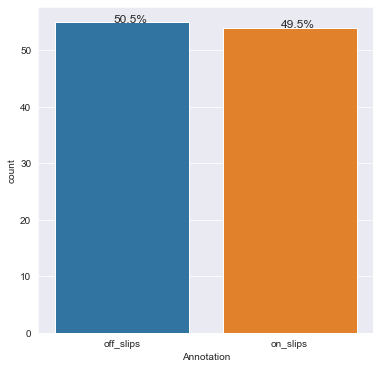

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax      = sns.countplot(data=annot, x='Annotation')
display_percent_count_plot(ax, annot['Annotation'],1)
plt.show()

As we can see, data is quite balanced; up to now, we don't have to worry about imbalanced target classes.

#### Numerical Features Analysis

Now I evaluate the central and dispersion metrics of the numerical variables.

In [13]:
## --- aggregating annotations according to the timestamp

time0 = annot.index[0]
df.loc[:time0, 'annot']     = annot.loc[time0].values[0]
no_nan.loc[:time0, 'annot'] = annot.loc[time0].values[0]


for time in annot.index[1:]:
    df.loc[time0:time, 'annot']     = annot.loc[time].values[0]
    no_nan.loc[time0:time, 'annot'] = annot.loc[time].values[0]
    time0 = time
    
timef = annot.index[-1]

df.loc[timef:, 'annot']     = annot.loc[timef].values[0]
no_nan.loc[timef:, 'annot'] = annot.loc[timef].values[0]

In [14]:
no_nan[no_nan.columns[:-1]] = no_nan[no_nan.columns[:-1]].astype(float)

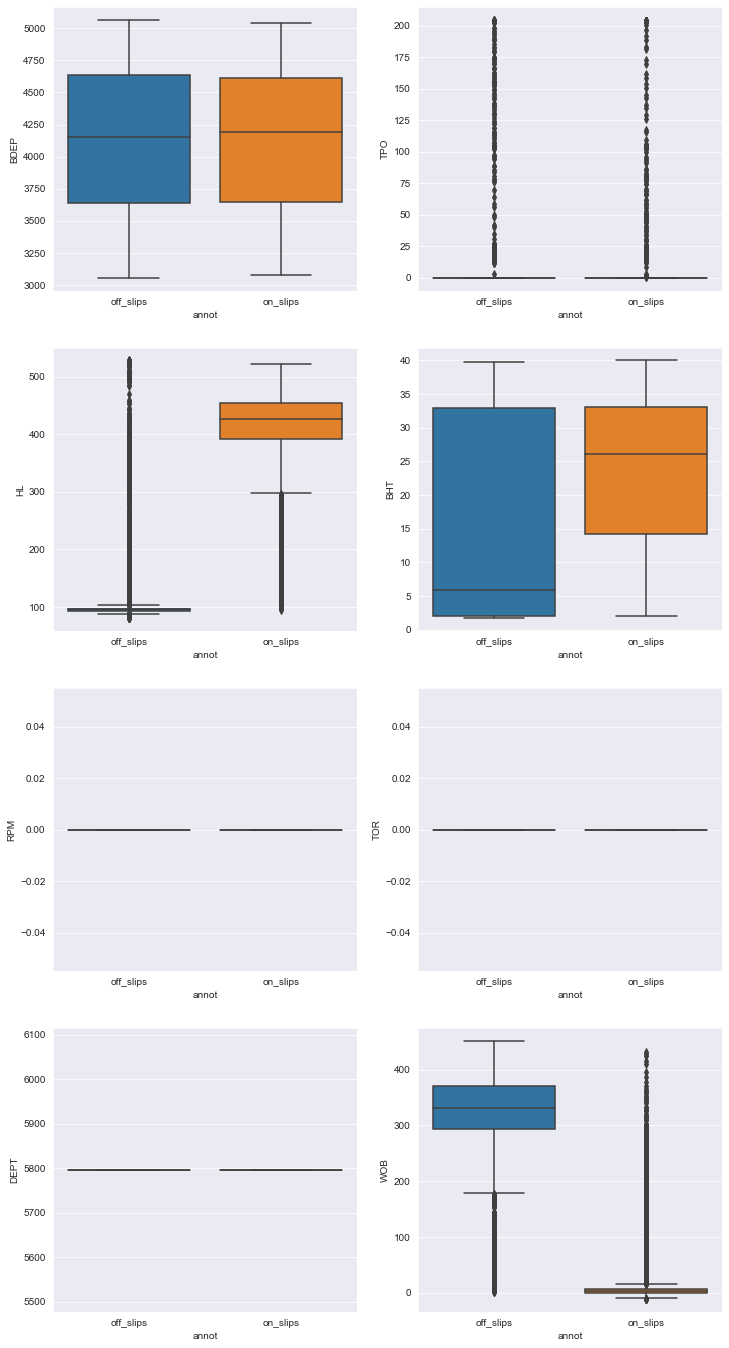

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(12,24))

for col, axis in zip(no_nan.columns[:-1].values, ax.reshape(-1)):
    sns.boxplot( data  = no_nan,
                 x     = 'annot',
                 y     = col,
                 ax    = axis)

As we can see from the above visualizations, according to the central tendency metrics for each one of the features, the most important variables to categorize the equipment operation according to the state of the slips are **HL** and **WOB**. Further, the variables **RPM**, **TOR**, and **DEPT** seem to not vary expressively. Let's have a closer look at these features.

In [16]:
no_nan['RPM'].unique(), no_nan['TOR'].unique(), no_nan['DEPT'].unique()

(array([0.]), array([0.]), array([5796.]))

It turns out that these features do not vary at all. Certainly, these features may not be that important to develop the desired KPI. Despite that conclusion, I'm going to hold these predictors until my hypothesis get confirmed by the following analysis of feature relevance performed by ML algorithms.

## Relevance Analysis

In this section, I use three different approaches to categorize the measurements by *Annotation*. I show a grid containing four 2-dimensional graphs referring to the importance of variables using the following algorithms: Logistic Regression, Random Forest Classifier and PCA. Furthermore, I show the explanatory cumulative variance given by the PCA algorithm, as well as the linear combination coefficients of the constructed principal components. 

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
BDEP,-0.141862,0.786060,0.132758,-0.586810,-0.006205,0.0,0.0,0.0
TPO,-0.033664,0.754743,-0.115787,0.644863,-0.000044,0.0,0.0,0.0
HL,-0.972580,0.050127,-0.206533,-0.091706,0.023098,0.0,0.0,0.0
BHT,-0.498126,-0.056267,0.846995,0.177001,-0.000031,0.0,0.0,0.0
RPM,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.0,0.0,0.0
TOR,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.0,0.0,0.0
DEPT,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.0,0.0,0.0
WOB,0.952016,0.165589,0.247869,-0.065714,0.022654,0.0,0.0,0.0


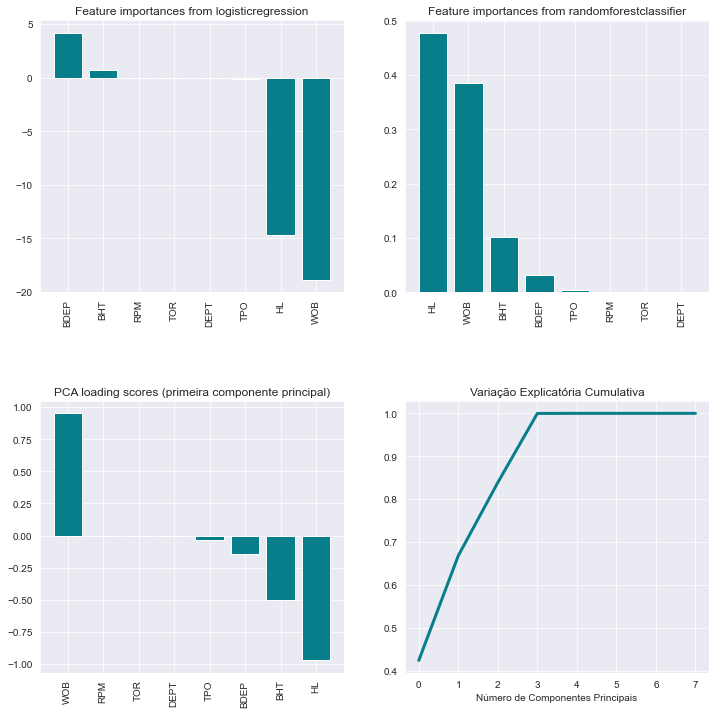

In [17]:
X = no_nan.drop(['annot'], axis=1).copy()
y = no_nan['annot'].apply(lambda x: 0 if x == 'off_slips' else 1).astype('int8')

fig, ax  = plt.subplots(2,2,figsize=(12,12))
loadings = display_feat_import(X, y, ax)
plt.subplots_adjust(hspace=0.4)
loadings

As we can see from above, all the approaches to determine the relevance of the features indicated that **RPM**, **TOR**, and **DEPT** play no role to categorize the state of the slips; this confirms my previous observations.

Furthermore, all methods indicated that the variable **TPO** is almost not important considering our goal. Finally, the cumulative explanatory variance tells us that the first three principal components are sufficient to describe one hundred per cent of the variation in the target variable.

Having said this, I'm going on without the three least important features, namely, **RPM**, **TOR**, and **DEPT**.

In [18]:
df.drop(['RPM', 'TOR', 'DEPT'], axis=1, inplace=True)
no_nan.drop(['RPM', 'TOR', 'DEPT'], axis=1, inplace=True)

## Correlation Analysis

Here we check for correlations between predictors, and how the numerical values of the predictors are distributed.


In [19]:
## --- Pair Plot
sns.pairplot(data      = no_nan, 
             hue       = 'annot', 
             kind      = 'kde', 
             diag_kind = 'kde', 
             corner    = True)

First, the above pair plot confirms our previous analysis of relevance.

Additionally, most of the distributions are not bell-shaped and some of them are left-skewed; it indicates that performing some transformation on the training data may improve the model accuracy. 

Furthermore, the distributions for the variable **BHT**, which is still important for classification, overlap; choosing a tree-based model may address well this issue.

<AxesSubplot:>

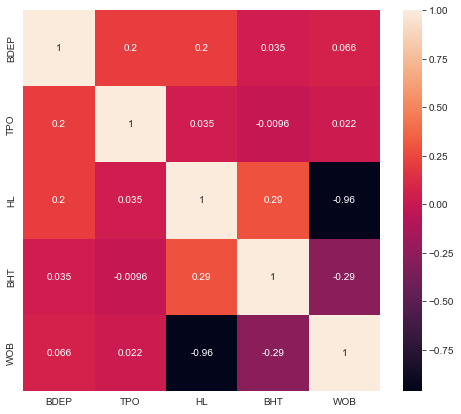

In [20]:
## --- Correlation Matrix
fig, ax = plt.subplots(1,1,figsize=(8,7))

sns.heatmap( no_nan.drop('annot', axis=1).corr(), annot=True, ax=ax)

As we can see from the correlation matrix, most of the variables are almost uncorrelated with each other. This suggests that a Naive Bayes model could do well in this classification task. 

On the other hand, the features **HL** and **WOB** are extremely correlated. This indicates that perhaps creating new variables from these can help in enhancing the model's performance. But before that, I'm going to select the baseline model without playing with the features.

## Base Line Models

#### Supervised learning models

To define the baseline supervised learning model, I will evaluate the performance of the following classification algorithms:  **RandomForestClassifier**, **LogisticRegression**, **SVC**, **GaussianNB**, **XGBClassifier**, **LGBMClassifier**. 

In [21]:
algo  = [RandomForestClassifier(), LogisticRegression(), SVC(), 
         GaussianNB(), XGBClassifier(), LGBMClassifier()]
score = []

    
X = df.drop(['annot'], axis=1).copy()
y = df['annot'].apply(lambda x: 0 if x == 'off_slips' else 1).astype('int8')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for a in algo:
    a.fit(X_train, y_train)
    y_pred = a.predict(X_test)
    score.append([a.__class__.__name__,
                 accuracy_score(y_test, y_pred), 
                 precision_score(y_test, y_pred),
                 recall_score(y_test, y_pred),
                 f1_score(y_test, y_pred)])

## --- show scores as tabular data
pd.DataFrame(score, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])


[14:03:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Accuracy,Precision,Recall,F1 Score
0,RandomForestClassifier,0.992624,0.994891,0.994166,0.994529
1,LogisticRegression,0.978119,0.975452,0.992525,0.983915
2,SVC,0.977382,0.973896,0.993072,0.983391
3,GaussianNB,0.977259,0.974400,0.992343,0.983290
4,XGBClassifier,0.995943,0.997082,0.996901,0.996992
5,LGBMClassifier,0.996066,0.997809,0.996354,0.997081


Most models excelled in classifying correctly the state of the slips but, as I expected, tree-based models outperformed all the other algorithms. These kind of models are less sensitive to outliers.

From now on, I'll use the LGBMClassifier.

##### Evaluating the LGBMClassifier

Let's have a look at the confusion matrix and the classification report for the selected model.

In [22]:
clf    = LGBMClassifier()
clf. fit(X_train, y_train)
y_pred = clf.predict(X_test)

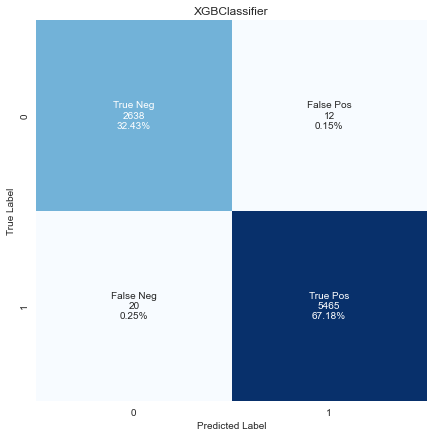

In [23]:
## --- Confusion Matrix

fig, ax = plt.subplots(1,1, figsize=(7,7))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=cf_matrix_labels(cm), fmt='', cmap='Blues', ax=ax, cbar=False)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('XGBClassifier')

plt.subplots_adjust(hspace=0.3)

From the confusion matrix above and the classification report below, we can state that the model is pretty reliable in classifying both classes.

In [24]:
print('LGBMClassifier')
print(classification_report(y_test, y_pred, target_names=['off_slips', 'on_slips']))
print('\n')

LGBMClassifier
              precision    recall  f1-score   support

   off_slips       0.99      1.00      0.99      2650
    on_slips       1.00      1.00      1.00      5485

    accuracy                           1.00      8135
   macro avg       1.00      1.00      1.00      8135
weighted avg       1.00      1.00      1.00      8135





#### Unsupervised learning models

To define the baseline unsupervised learning model, I will evaluate the performance of the **K-means Clustering** classification algorithm

In [25]:
algo  = [ KMeans(n_clusters=2, copy_x=False, random_state=42)]
score = []
    
X      = df.drop(['annot'], axis=1).copy()
y_test = df['annot'].apply(lambda x: 0 if x == 'off_slips' else 1).astype('int8')


for a in algo:

    a.fit(X)
    y_pred = pd.Series(a.predict(X)).apply(lambda x: 0 if x == 1 else 1).astype('int8')
    score.append([a.__class__.__name__,
                 accuracy_score(y_test, y_pred), 
                 precision_score(y_test, y_pred),
                 recall_score(y_test, y_pred),
                 f1_score(y_test, y_pred)])

## --- show scores as tabular data
pd.DataFrame(score, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])


,Model,Accuracy,Precision,Recall,F1 Score
0,KMeans,0.532614,0.679136,0.573975,0.622143


According to the above results, this model may not be a good fit for a baseline model. Although its performance could be augmented, we already have a supervised learning model that performs quite well; there's no point in spending time with an unsupervised model. 

Further, unsupervised learning models have some cons: 
1) The results might be less accurate as we do not have any input data to train from. The model is learning from raw data without any prior knowledge.

2) It is also a time-consuming process. The learning phase of the algorithm might take a lot of time, as it analyses and calculates all possibilities.

3) For some projects involving live data, which may be the case, it might require continuous feeding of data to the model, which will result in both inaccurate and time-consuming results.

## Feature Engineering

Now I go for improving the performance of the LGBMClassifier by working with the features we have. To give me more reliability on the resulting scores, I'm performing a 5-fold cross validation from now on.

Since the features **WOB** and **HL** are extremelly correlated, I propose creating a new variable called **WOBHL_ratio** which is simply $WOB/HL$.



In [26]:
bckup_df = df.copy()
bckup_df['WOBHL_ratio'] = bckup_df['WOB']/bckup_df['HL']
bckup_df.drop(['WOB','HL'], axis=1, inplace=True)

In [27]:
X = bckup_df.drop(['annot'], axis=1).copy()
y = bckup_df['annot'].apply(lambda x: 0 if x == 'off_slips' else 1).astype('int8')


kf = KFold(n_splits=5, random_state=3, shuffle=True)

xval_err = 0

for train_index, test_index in kf.split(bckup_df):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf = LGBMClassifier()
    clf. fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    xval_err += accuracy_score(y_test, y_pred)

accur_5cv = xval_err/5
accur_5cv


0.995697364171637

As one could expect, there's no improvement, since tree-based models have an innate feature of being robust to correlated features. On the other hand, this may improve the performance of other kinds of models such as the GaussianNB classifier, for instance.

Additionally, we could benefit from removing the least important feature namely, TOP, since it plays almost no role in the model performance. That'd make the model simpler and faster.


## Hyperparameter Fine Tuning

Finally, I will fine-tune the LGBMClassifier algorithm to find the parameter combination that delivers the best possible performance. The best possible performance is the one that gives the highest f1 score since that to have a good KPI we need both to detect whenever the slip-to-slip connection changes its state, and give accurate indications about the connection state.

In [28]:
param_grid = {'n_estimators'       : [50,70,90],  
              'max_depth'          : [-1,5,10],
              'learning_rate'      : [0.95,0.1,1.15],
              'boosting_type'      : ['gbdt','goss','dart', 'rf']
             }
                
grid = GridSearchCV(LGBMClassifier(), 
                    param_grid, 
                    refit   = True, 
                    verbose = 3, 
                    n_jobs  = -1, 
                    scoring ='f1') 

## --- fitting GridSearch
grid_result = grid.fit(X, y)
best_params = grid_result.best_params_
print(best_params)

Let's see the final performance.

In [29]:
X = bckup_df.drop(['annot'], axis=1).copy()
y = bckup_df['annot'].apply(lambda x: 0 if x == 'off_slips' else 1).astype('int8')


kf = KFold(n_splits=5, random_state=3, shuffle=True)

xval_err = 0

for train_index, test_index in kf.split(bckup_df):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf = LGBMClassifier(n_estimators  = 50, 
                         max_depth     = 10, 
                         learning_rate = 0.1,
                         boosting_type = 'dart')
    clf. fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    xval_err += f1_score(y_test, y_pred)

f1_5cv = xval_err/5
f1_5cv


0.995395936156147

In [30]:
print('LGBMClassifier')
print(classification_report(y_test, y_pred, target_names=['off_slips', 'on_slips']))
print('\n')

LGBMClassifier
              precision    recall  f1-score   support

   off_slips       0.99      0.99      0.99      2739
    on_slips       1.00      0.99      0.99      5395

    accuracy                           0.99      8134
   macro avg       0.99      0.99      0.99      8134
weighted avg       0.99      0.99      0.99      8134





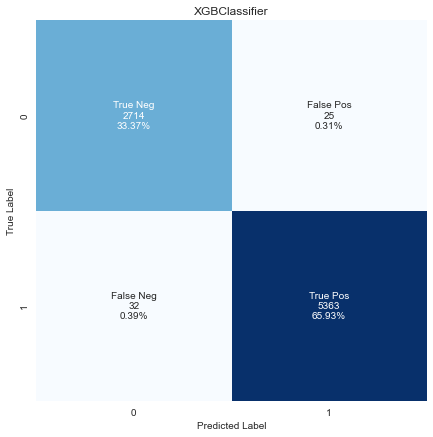

In [31]:
## --- Confusion Matrix

fig, ax = plt.subplots(1,1, figsize=(7,7))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=cf_matrix_labels(cm), fmt='', cmap='Blues', ax=ax, cbar=False)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('XGBClassifier')

plt.subplots_adjust(hspace=0.3)

## Using the Model to Create a KPI

At this point we are able to estimate the slip-to-slip connection time using the developed model. I start by calculating the average time in slips according to the labeled given data.

In [32]:
## --- selecting the indexes of groups where 'on_slips' is True

group = []
indxs = []
for index, row in bckup_df.iterrows():
    if row['annot'] == 'on_slips':
        group.append(index)
    else:
        indxs.append(group)
        group = []

sel   = pd.Series(indxs).apply(lambda x: x != [])
indxs = np.array(indxs)[sel]

In [33]:
## --- Calculating the average time in slips
avg = 0
for l in indxs:
    avg += l[-1] - l[0]

print('Average time in slips %.3f s' % (avg/len(indxs)*1e-3))

Average time in slips 251.995 s


Now I use the model to make predictions.

In [35]:
clf = LGBMClassifier(n_estimators  = 50, 
                     max_depth     = 10, 
                     learning_rate = 0.1,
                     boosting_type = 'dart')

X = bckup_df.drop('annot', axis=1).copy()
y = bckup_df['annot'].apply(lambda x: 0 if x == 'off_slips' else 1).astype('int8')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size    = 0.1, 
                                                    random_state = 42)


clf.fit(X_train, y_train)
bckup_df['annot'] = clf.predict(bckup_df.drop('annot', axis=1).copy())

In [36]:
## --- selecting the indexes of groups where 'on_slips' is True

group = []
indxs = []
for index, row in bckup_df.iterrows():
    if row['annot'] == 1:
        group.append(index)
    else:
        indxs.append(group)
        group = []

sel   = pd.Series(indxs).apply(lambda x: x != [])
indxs = np.array(indxs)[sel]

In [37]:
## --- Calculating the average time in slips
avg = 0
for l in indxs:
    avg += l[-1] - l[0]

print('Average time in slips %.3f (s)' % (avg/len(indxs)*1e-3))

Average time in slips 222.987 (s)


The predicted average time in slips obtained from the model's predictions deviates about 10% from the previously calculated value. Although this seems to be a good performance, this result might not be taken too seriously; it'd be better to evaluate this performance on previously unseen labelled data. This could be achieved by separating part of the given data set as validation data.

## Concluding Remarks

After performing an exploratory data analysis, the statistical metrics showed us which features are the most important considering the goal of this project. Subsequently, my findings were confirmed by the relevance analysis performed by machine learning; the features TOR, DEPT, and RPM can be removed to simplify the final model.

Besides that, the correlation analysis told us that most features are extremely uncorrelated, which gave me an idea of which algorithms I should select to start the modelling. The finds suggested that tree-based models would be a good fit for the task, which was confirmed by the classification reports.

In summary, the supervised learning algorithm LGBMClassifier outperformed all the other tested algorithms including the unsupervised-learning one K-Means Clustering. From the evaluation metrics, we can safely say that, considering the given data, the model can accurately capture the operational state of the slips with 99% precision. The estimated average connection time deviates only 10% from the connection time calculated with the labelled data.

Finally, the developed solution seems to be reliable and can be used for automated monitoring of performance on drilling operations for any O&G industry.

#### Possible next steps

As a possible next step, if I had more time, I'd put this model in production on a cloud environment so that it can receive requests from other applications to stream predictions and deliver the wanted KPI. 

Additionally, I'd like to evaluate how this model would perform on previously unseen data.